## NOTE

#### This notebook requires more than 12 GB RAM to run as it deals with lots of image processing on the memory. If you are running on a smaller ram that that, please go back to Hub Control Panel and start a new session with a larger RAM configuration

## Install required dependencies

In [2]:
! pip3 install utm
! pip3 install scikit-image
! pip3 install geopy
! pip3 install shapely
! pip3 install boto3
! pip3 install rasterio
! pip3 install fiona
! pip3 install osmnx
! pip3 install geopy

  Using cached utm-0.7.0-py3-none-any.whl
  Using cached osmnx-1.9.1-py3-none-any.whl.metadata (4.9 kB)
Using cached osmnx-1.9.1-py3-none-any.whl (104 kB)


## Import relevant libraries

In [5]:
try:
    import gdal
except ImportError:
    from osgeo import gdal

import utm
import numpy as np
import os
import getpass
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from rasterio.io import MemoryFile
from rio_cogeo.profiles import cog_profiles
from rio_cogeo.cogeo import cog_translate
import boto3
import rasterio
from pathlib import Path

from bm_scripts import LandsatUtils
from bm_scripts import GISUtils
from bm_scripts import VNP46A2Utils
from bm_scripts import OSMUtils


### Loading AWS Credentials

This notebook requires AWS credentials of a user to download the Landast dataset which is required to generate the Black Marble data product. Following cell shows how to derrive those credentials from the AWS Role which was injected into VEDA Hub's notebook session. However, if you are running the notebook outside of the VEDA HUB, make sure to manually update respective access credetials of following cell

In [6]:
aws_region = os.environ['AWS_REGION']
aws_role_arn = os.environ['AWS_ROLE_ARN']
aws_sts_regional_endpoints = os.environ['AWS_STS_REGIONAL_ENDPOINTS']
with open(os.environ['AWS_WEB_IDENTITY_TOKEN_FILE']) as f:
    aws_id_token = f.read()

role = boto3.client('sts').assume_role_with_web_identity(RoleArn=aws_role_arn, 
                                                         RoleSessionName='assume-role', 
                                                         WebIdentityToken=aws_id_token)
credentials = role['Credentials']
aws_access_key = credentials['AccessKeyId']
aws_secret_key = credentials['SecretAccessKey']
aws_session_token = credentials['SessionToken']

### Enter Earth Data Token

Earth data token is requred to download night time data prodcuts from NASA's darth data catalog. To create or fetch an existing token, go to https://urs.earthdata.nasa.gov/. If you do not have an account, you might have to create one first

In [7]:
print("Earch data token")
earth_data_token = getpass.getpass()

Earch data token


 ········


## Input Parameters to generate Black Marble data products

Algorithm requires the diagonal coordinates of the bounding box in WGS84 format. As the temporal parameters, year, month and day is required

In [8]:
# Baseline Test Case
lat1,long1,lat2,long2 =  33.034682, 21.279194, 32.465949, 22.919832
year = 2023
month = 1
day = 24

In [9]:
# Hurricane Maria
lat1,long1,lat2,long2 = 17.912138994450856, -67.27167653359618,18.51569455671654, -65.57478762584185
year = 2017
month = 7
day = 21

In [10]:
#Hurricane Ida
lat1,long1,lat2,long2 = 29.804659612978707, -90.3037818244749,30.07177072705947, -89.87578181971654
year = 2021
month = 8
day = 9

In [11]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle

watercolor = basemap_to_tiles(basemaps.Stadia.StamenTerrain)
m = Map(layers=(watercolor, ), center=((lat1 + lat2)/2 , (long1 + long2)/2), zoom=9)
rectangle = Rectangle(bounds=((lat1, long1), (lat2, long2)))
m.add(rectangle)


Map(center=[29.938215170019088, -90.08978182209572], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Create the directory strcuture to download input data and store intermediate and final outputs

In [12]:
Path("outputs").mkdir(parents=True, exist_ok=True)
Path("outputs/temp").mkdir(parents=True, exist_ok=True)
Path("outputs/final").mkdir(parents=True, exist_ok=True)

Initialize the utility class to download Landsat dataset. This class contains methods to accept WGS84 coordinates and convert those into Worldwide Reference System-2 (WRS-2) format. Using the conversion, there are utility methods to download required tiles from Landsat data S3 bucket. 

In [13]:
landsat_utils = LandsatUtils(aws_access_key, aws_secret_key, aws_session_token, shapefile="./WRS2_descending_0/WRS2_descending.shp")
gis_utils = GISUtils()

/srv/conda/envs/notebook/lib/python3.11/site-packages/osgeo/ogr.py:593: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Download and merge Landsat tiles

This downloads Lansat tiles for the given bounding box and date. In addition to the tiles for the particular date, it will download additional 12 tiles for previous 12 months to calculate composite outputs. Composite outputs are used to remove clouds and mitigate dispatirites captured on QA flags. Outputs are the files paths for B3, B4 and B5 band tiles along with QA flags those bands. If the given bounding box exceed a extent of a tile in WRS2 grid, this will download the rest of the tiles and merge those into one image.

In [14]:
b3_outputs, b4_outputs, b5_outputs, qa_pixel, qa_radsat, sr_qa_aerosol = landsat_utils.download_all_bands(
    year, month, day, 
    lat1, long1, lat2, long2)

Data Directory  collection02/level-2/standard/oli-tirs/2021/022/039/LC08_L2SP_022039_20210818_20210827_02_T1/
Completed downloading for band  3  Date  2021 - 8 - 9
Data Directory  collection02/level-2/standard/oli-tirs/2021/022/039/LC08_L2SP_022039_20210802_20210811_02_T1/
Completed downloading for band  3  Date  2021 - 8 - 1
Data Directory  collection02/level-2/standard/oli-tirs/2021/022/039/LC08_L2SP_022039_20210701_20210708_02_T1/
Completed downloading for band  3  Date  2021 - 7 - 1
Data Directory  collection02/level-2/standard/oli-tirs/2021/022/039/LC08_L2SP_022039_20210615_20210622_02_T1/
Completed downloading for band  3  Date  2021 - 6 - 1
Data Directory  collection02/level-2/standard/oli-tirs/2021/022/039/LC08_L2SP_022039_20210514_20210525_02_T1/
Completed downloading for band  3  Date  2021 - 5 - 1
Data Directory  collection02/level-2/standard/oli-tirs/2021/022/039/LC08_L2SP_022039_20210412_20210423_02_T1/
Completed downloading for band  3  Date  2021 - 4 - 1
Data Directory  

### Crop downloded tiles into the bounding box

This will crop the downloaded tiles into the exact bounding box provided by the input coordinate 

In [15]:
b3_final, b4_final, b5_final, p_final, r_final, a_final = gis_utils.crop_products_to_bb(lat1, long1, lat2, long2, 
                                                                              b3_outputs, b4_outputs, b5_outputs, 
                                                                              qa_pixel, qa_radsat, sr_qa_aerosol)



### Apply quality flags for bands

This is the last stage of pre processing of the Landsat data. We use the quality flags to turn off pixels which are not proprtly captured from satellites. More information on these quality flags can be found from here https://www.usgs.gov/landsat-missions/landsat-collection-2-quality-assessment-bands

In [16]:
b3_pxs = []
b4_pxs = []
b5_pxs = []
for i in range(len(b3_final)):
    p_px, in_geo, projref  = gis_utils.get_geo(p_final[i], 1)
    a_px, in_geo, projref  = gis_utils.get_geo(a_final[i], 1)
    r_px, in_geo, projref  = gis_utils.get_geo(r_final[i], 1)
    
    cloud_pixels = landsat_utils.mark_cloud(p_px)
    aerosol_pixels = landsat_utils.mark_aerosol(a_px)
    
    b3_r_px, b4_r_px, b5_r_px = landsat_utils.mark_radsat(r_px)
    
    b3_px, in_geo, projref  = gis_utils.get_geo(b3_final[i], 1)
    b4_px, in_geo, projref  = gis_utils.get_geo(b4_final[i], 1)
    b5_px, in_geo, projref  = gis_utils.get_geo(b5_final[i], 1)
    
    b3_px = b3_px  * cloud_pixels * aerosol_pixels * b3_r_px
    b4_px = b4_px  * cloud_pixels * aerosol_pixels * b4_r_px
    b5_px = b5_px  * cloud_pixels * aerosol_pixels * b5_r_px
    
    b3_pxs.append(np.array(b3_px))
    b4_pxs.append(np.array(b4_px))
    b5_pxs.append(np.array(b5_px))



### Calculate the composite output for bands

Now we have 12 layers for each band representing 12 months back starting from the input date. The pixels for each layer which were identified by QA flags were set to 0. In this cell, those 12 layers are flattend based on the median of corresponding pixels 

In [17]:
b3 = np.nanmedian(np.where(np.stack(b3_pxs) == 0, np.nan, np.stack(b3_pxs)), axis=0)
b3_pxs = None
b4 = np.nanmedian(np.where(np.stack(b4_pxs) == 0, np.nan, np.stack(b4_pxs)), axis=0)
b4_pxs = None
b5 = np.nanmedian(np.where(np.stack(b5_pxs) == 0, np.nan, np.stack(b5_pxs)), axis=0)
b5_pxs = None

/tmp/ipykernel_1073/3048344826.py:1: RuntimeWarning: All-NaN slice encountered
  b3 = np.nanmedian(np.where(np.stack(b3_pxs) == 0, np.nan, np.stack(b3_pxs)), axis=0)
/tmp/ipykernel_1073/3048344826.py:3: RuntimeWarning: All-NaN slice encountered
  b4 = np.nanmedian(np.where(np.stack(b4_pxs) == 0, np.nan, np.stack(b4_pxs)), axis=0)
/tmp/ipykernel_1073/3048344826.py:5: RuntimeWarning: All-NaN slice encountered
  b5 = np.nanmedian(np.where(np.stack(b5_pxs) == 0, np.nan, np.stack(b5_pxs)), axis=0)


### Save final band pixels into GeoTiff files

In [18]:
gis_utils.save_geotiff_single("outputs/B3.tif", b3, projref, in_geo)
b3 = None
gis_utils.save_geotiff_single("outputs/B4.tif", b4, projref, in_geo)
b4 = None
gis_utils.save_geotiff_single("outputs/B5.tif", b5, projref, in_geo)
b5 = None

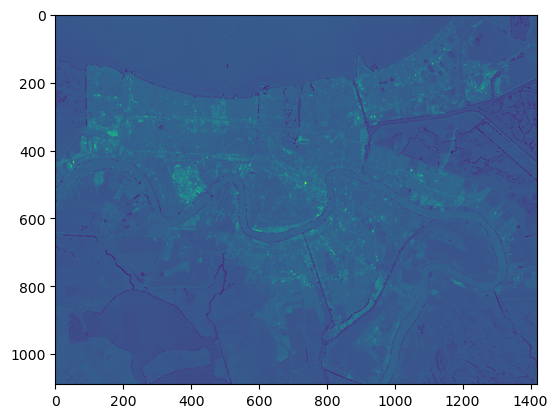

In [19]:
img = mpimg.imread('outputs/B3.tif')
imgplot = plt.imshow(img)
plt.show()

### Convert bands into WGS84

Landsat data is recorded in UTM coordinate system. In Black Marble data products, we want all the input images to be in WGS84 fomat. Here we convert band images saved from previous step into that target coordinate system

In [20]:
gis_utils.convert_to_wgs84("outputs/B3.tif", "outputs/B3_WGS84.tif", long1, lat1, long2, lat2)
gis_utils.convert_to_wgs84("outputs/B4.tif", "outputs/B4_WGS84.tif", long1, lat1, long2, lat2)
gis_utils.convert_to_wgs84("outputs/B5.tif", "outputs/B5_WGS84.tif", long1, lat1, long2, lat2)

### Download VNP46A2 products

VNP46A2 is the night time data product that can be downloaded from NASA Eath Data Catalog. This data product is distributed in HDF5 format with 7 layers. We use "Gap-Filled DNB BRDF-Corrected NTL" layer with assiciated quality flags to derrive the night time image for the given bounding box and data. More information for this product can be found from https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP46A2/

In [21]:
# Download night images

vnp46Util = VNP46A2Utils()


gap_filled = []
qf = []
cloud_mask = []
snow_flag = []

vertical1, horizontal1 = vnp46Util.coordinates_to_tile_id(lat1, long1)
vertical2, horizontal2 = vnp46Util.coordinates_to_tile_id(lat2, long2)
download_file = "VNP46A2.h5"
if vertical1 == vertical2 and horizontal1 == horizontal2:
    vnp46Util.download_h5(earth_data_token, year, month, day, vertical1, horizontal1, download_file)
    vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "gap_filled_dnb_brdf_corrected_ntl.tif", 2)
    vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "mandatory_quality_flag.tif", 4)
    vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "qf_cloud_mask.tif", 5)
    vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, "snow_flag.tif", 6)
else:

    tile_ids = [(vertical1, horizontal1), (vertical2, horizontal1), (vertical1, horizontal2), (vertical2, horizontal2)]
    for i, tile_id in enumerate(tile_ids):
        vertical, horizontal = tile_id
        vnp46Util.download_h5(earth_data_token, year, month, day, vertical, horizontal, download_file)
        vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, str(i) + "gap_filled_dnb_brdf_corrected_ntl.tif", 2)
        vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, str(i) + "mandatory_quality_flag.tif", 4)
        vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, str(i) + "qf_cloud_mask.tif", 5)
        vnp46Util.convert_VNP46A2_HDF2TIFF(download_file, str(i) + "snow_flag.tif", 6)   
        gap_filled.append(str(i) + "gap_filled_dnb_brdf_corrected_ntl.tif")
        qf.append(str(i) + "mandatory_quality_flag.tif")
        cloud_mask.append(str(i) + "qf_cloud_mask.tif")
        snow_flag.append(str(i) + "snow_flag.tif")

        
    g = gdal.Warp("gap_filled_dnb_brdf_corrected_ntl.tif", 
                              gap_filled, format="GTiff", options=["COMPRESS=LZW", "TILED=YES"], 
                              resampleAlg='bilinear',  multithread=True) # if you want
    g = None

    g = gdal.Warp("mandatory_quality_flag.tif", 
                              qf, format="GTiff", options=["COMPRESS=LZW", "TILED=YES"], 
                              resampleAlg='bilinear',  multithread=True) # if you want
    g = None

    
    g = gdal.Warp("qf_cloud_mask.tif", 
                              cloud_mask, format="GTiff", options=["COMPRESS=LZW", "TILED=YES"], 
                              resampleAlg='bilinear',  multithread=True) # if you want
    g = None

    g = gdal.Warp("snow_flag.tif", 
                              snow_flag, format="GTiff", options=["COMPRESS=LZW", "TILED=YES"], 
                              resampleAlg='bilinear',  multithread=True) # if you want
    g = None
    
gfdbcn, in_geo, projref  = gis_utils.get_geo("gap_filled_dnb_brdf_corrected_ntl.tif", 1)
gfdbcn = np.where(gfdbcn == 65535, 0, gfdbcn)
gis_utils.save_geotiff_single("gap_filled_dnb_brdf_corrected_ntl.tif", gfdbcn, projref, in_geo)


maxY = max(lat1, lat2)
minY = min(lat1, lat2)
maxX = max(long1, long2)
minX = min(long1, long2)
scale = 0.00011111111

gis_utils.subset_raster_normal("gap_filled_dnb_brdf_corrected_ntl.tif", "outputs/gap_filled_dnb_brdf_corrected_ntl.tif", minX, maxY, maxX, minY, scale) 
gis_utils.subset_raster_normal("mandatory_quality_flag.tif", "outputs/mandatory_quality_flag.tif", minX, maxY, maxX, minY, scale) 
gis_utils.subset_raster_normal("qf_cloud_mask.tif", "outputs/qf_cloud_mask.tif", minX, maxY, maxX, minY, scale) 
gis_utils.subset_raster_normal("snow_flag.tif", "outputs/snow_flag.tif", minX, maxY, maxX, minY, scale) 

gap_filled_ntl, in_geo, projref  = gis_utils.get_geo("outputs/gap_filled_dnb_brdf_corrected_ntl.tif", 1)
adjusted_ntl =  np.where(gap_filled_ntl > 65534, 0, gap_filled_ntl) # * 0.1 # scale factor

# Final night time image is saved
gis_utils.save_geotiff_single("outputs/adjusted_ntl.tif", adjusted_ntl, projref, in_geo)


{'archiveSets': 5000, 'cksum': '3181989137', 'dataDay': '2021-221 = 2021-08-09', 'downloadsLink': 'https://ladsweb.modaps.eosdis.nasa.gov/api/v2/content/archives/allData/5000/VNP46A2/2021/221/VNP46A2.A2021221.h08v06.001.2021283130759.h5', 'fileId': 6545465268, 'md5sum': '3b7940c21187e95785b1b74432da48fb', 'mtime': 1633872914, 'name': 'VNP46A2.A2021221.h08v06.001.2021283130759.h5', 'products': 'VNP46A2', 'resourceType': 'File', 'self': '/api/v2/content/details/allData/5000/VNP46A2/2021/221/VNP46A2.A2021221.h08v06.001.2021283130759.h5', 'size': 2321200}
File downloaded successfully
('HDF5:"VNP46A2.h5"://HDFEOS/GRIDS/VNP_Grid_DNB/Data_Fields/Gap_Filled_DNB_BRDF-Corrected_NTL', '[2400x2400] //HDFEOS/GRIDS/VNP_Grid_DNB/Data_Fields/Gap_Filled_DNB_BRDF-Corrected_NTL (16-bit unsigned integer)')
('HDF5:"VNP46A2.h5"://HDFEOS/GRIDS/VNP_Grid_DNB/Data_Fields/Mandatory_Quality_Flag', '[2400x2400] //HDFEOS/GRIDS/VNP_Grid_DNB/Data_Fields/Mandatory_Quality_Flag (8-bit unsigned character)')
('HDF5:"VNP4

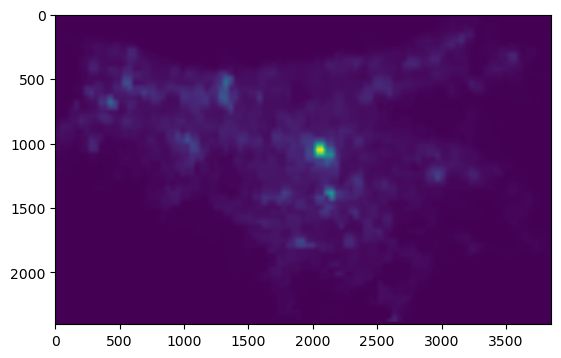

In [23]:
img = mpimg.imread('outputs/adjusted_ntl.tif')
imgplot = plt.imshow(img)
plt.show()

### Download the open street map data product

Open Street Map provides the road systems of the world as graph represntation. We use that graph and convert it into a GeoTiff for the given bounding box. It uses the geo location parameters from the night time image generated in the previous cell

In [24]:
# Download openstreet maps
osm_utl = OSMUtils()
osm_utl.create_road_raster(lat1, long1, lat2, long2,  output_path="outputs/osm.tif", 
                           raster_value = 1, path_thickness = 0.00005, reference_raster = "outputs/adjusted_ntl.tif")

/home/jovyan/bm_scripts/__init__.py:584: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(max(lat1, lat2),
/home/jovyan/bm_scripts/__init__.py:591: FutureWarning: The `save_graph_shapefile` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  ox.save_graph_shapefile(G, "roads")
/srv/conda/envs/notebook/lib/python3.11/site-packages/osmnx/io.py:114: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
/home/jovyan/bm_scripts/__init__.py:584: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter ins

In [ ]:
img = mpimg.imread('outputs/osm.tif')
fig, axes = plt.subplots(1, 1, figsize=(8, 6))  # Create subplots for two images
im1 = axes.imshow(img,vmin=0, vmax=5, cmap='jet', aspect='auto')
axes[0].set_title('Street View')
fig.colorbar(im1, orientation='vertical')

plt.tight_layout()
plt.show()

TypeError: 'Axes' object is not subscriptable

### Scale all the input images 

Now we have 3 Bands from Landsat, Night time image and the open street map image in GeoTiff and WGS84 format. Then we need to being all images into one resolution. We use the standard 10m resolution where each pixel represent a 10 m x 10 m are of the earth.

In [27]:

input_files = ['outputs/B3_WGS84.tif', 'outputs/B4_WGS84.tif', 'outputs/B5_WGS84.tif',
               'outputs/adjusted_ntl.tif', 'outputs/osm.tif'] 

# Output file names
output_files = ['outputs/final/B3.tif', 'outputs/final/B4.tif', 
                'outputs/final/B5.tif', 
                'outputs/final/ntl.tif', 'outputs/final/osm.tif']

# Desired resolution
desired_resolution = (0.0001, -0.0001)  # Replace with your desired resolution in degrees (x_resolution, y_resolution)

# Loop through each input file
for i, input_file in enumerate(input_files):
    output_file = output_files[i]
    # Open the input dataset
    input_dataset = gdal.Open(input_file)
    # Perform the resampling to the desired resolution
    gdal.Warp(output_file, input_dataset, format='GTiff', xRes=desired_resolution[0], yRes=desired_resolution[1])
    # Close the input dataset
    input_dataset = None

b3_final_px, in_geo, projref = gis_utils.get_geo('outputs/final/B3.tif', 1)
b4_final_px, _, _ = gis_utils.get_geo('outputs/final/B4.tif', 1)
b5_final_px, _, _ = gis_utils.get_geo('outputs/final/B5.tif', 1)
osm_final_px, _, _ = gis_utils.get_geo('outputs/final/osm.tif', 1)
ntl_final_px, _, _ = gis_utils.get_geo('outputs/final/ntl.tif', 1)

gaps_filed_stack = gis_utils.fill_gaps([b3_final_px, b4_final_px, b5_final_px, osm_final_px, ntl_final_px])

b3_final_px = landsat_utils.rescale_bands(gaps_filed_stack[0])
b4_final_px = landsat_utils.rescale_bands(gaps_filed_stack[1])
b5_final_px = landsat_utils.rescale_bands(gaps_filed_stack[2])
osm_final_px = gaps_filed_stack[3]
ntl_final_px = gaps_filed_stack[4]

### Calculate NDVI and NDWI products

Using band 3, 4 and 5 final outputs, we calculate the NDVI and NDWI products. NDVI highlights areas where vegitation is significant and NDWI shows areas where water is visible.

In [28]:
ndvi = (b5_final_px - b4_final_px) / (b5_final_px + b4_final_px)
ndwi = (b3_final_px - b5_final_px) / (b3_final_px + b5_final_px)

b3_final_px = None
b4_final_px = None
b5_final_px = None

ndvi = np.where(ndvi > 1, 1.0, ndvi)
ndvi = np.where(ndvi < -1, -1.0, ndvi)

ndwi = np.where(ndwi > 1, 1.0, ndwi)
ndwi = np.where(ndwi < -1, -1.0, ndwi)

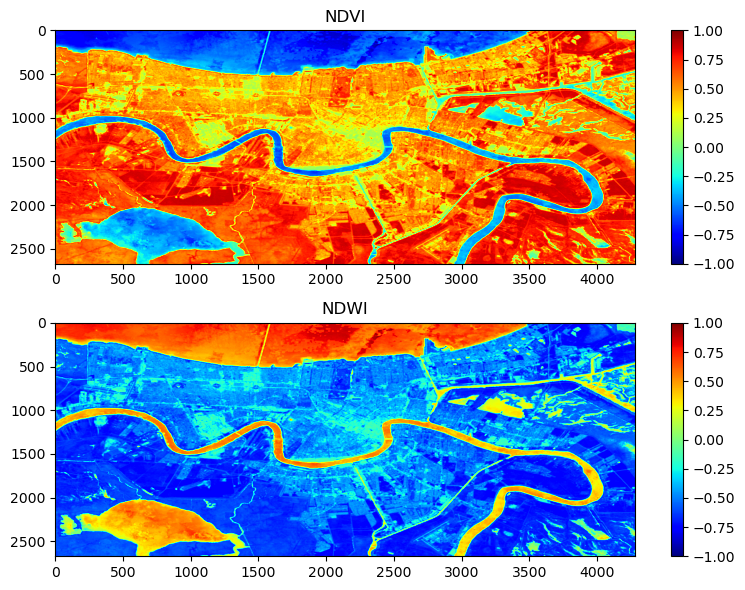

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # Create subplots for two images
im1 = axes[0].imshow(ndvi,vmin=-1, vmax=1, cmap='jet', aspect='auto')
axes[0].set_title('NDVI')
fig.colorbar(im1, orientation='vertical')
#axes[0].axis('off')

im2 = axes[1].imshow(ndwi,vmin=-1, vmax=1, cmap='jet', aspect='auto')
axes[1].set_title('NDWI')
fig.colorbar(im2, orientation='vertical')
#axes[1].axis('off')

plt.tight_layout()
plt.show()

# Generate Balck Marble Data Products

Finally we calculate the Black Marble Data product using NDWI, NDVI, Night Time Image and Open Street Map Image. This is a RGBA image which shows a high definition representation of night lights

In [33]:
ntl_floor = 0.1
ntl_ceiling = 10
ndui_floor = 0.02

##############Read Images as Array################
img_road = osm_final_px
img_ndvi = ndvi
img_ndwi = ndwi
img_ntl = ntl_final_px

#make nodate (65535) as zero
img_ntl =  np.where(img_ntl > 65534, 0, img_ntl)

#Scale Radiance value If needed
img_ntl = img_ntl.astype(float)
img_ntl = img_ntl/10

###############Calculate NDUI#############################
img_ntl = np.where(img_ntl > ntl_ceiling, ntl_ceiling, img_ntl)
img_ntl = np.where(img_ntl < ntl_floor, 0.0, img_ntl)
img_ntl = img_ntl/ntl_ceiling

ndui = (((img_ntl - img_ndvi))/((img_ntl + img_ndvi + 0.00001)))

ndui = np.where(ndui > 1.0, 1.0, ndui)
ndui = np.where(ndui < -1.0, -1.0, ndui)

#Apply Water Mask
ndui = np.where(img_ndwi >= 0.0, -1.0, ndui)

ndui  = abs((ndui+1.0))/2.0
ndui = np.where(ndui < ndui_floor, 0.0, ndui)

#increase intensity for roads
ndui = np.where((img_road == 1)|(img_road == 4), ndui*1.3, ndui)
ndui = np.where((img_road == 2)|(img_road == 3)|(img_road == 5)|(img_road == 6), ndui*1.1, ndui)

ndui = ndui / 1.3

output_co = "outputs/final/ndui-co.tif"

#### Output Image Scale Range from 0 to 1 (Best display value 0.3 - 0.8)##############
min_value = 0.3
max_value = 0.8

r = np.load('inferno_r.npy')
g = np.load('inferno_g.npy')
b = np.load('inferno_b.npy')

r[0] = 0
g[0] = 0
b[0] = 0

img_ndui_scale = gis_utils.scale_image(ndui, min_value, max_value)

post_rr = r[img_ndui_scale]
post_gg = g[img_ndui_scale]
post_bb = b[img_ndui_scale]

### Generate the final Cloud Optimized GeoTiff for Black Marble Data Product

In [34]:
alpha = np.full(post_bb.shape, 255, dtype=np.uint8)

with rasterio.open('outputs/final/B3.tif') as src: # Get metadata information from a processed B3
        arr = src.read()
        kwargs = src.meta
    
kwargs['dtype'] = 'uint8'
kwargs['count'] = 4
arr = np.array([post_rr, post_gg, post_bb, alpha]).astype(np.uint8)

kwargs.update(driver="GTiff", predictor=2)
with MemoryFile() as memfile:
    # Opening an empty MemoryFile for in memory operation - faster
    with memfile.open(**kwargs) as mem:
        # Writing the array values to MemoryFile using the rasterio.io module
        # https://rasterio.readthedocs.io/en/stable/api/rasterio.io.html
        mem.write(arr)

        dst_profile = cog_profiles.get("deflate")
        dst_profile['nodata'] = 0

        config = dict(
        GDAL_NUM_THREADS="ALL_CPUS",
        GDAL_TIFF_OVR_BLOCKSIZE="256",
        )
        # Creating destination COG
        cog_translate(
            mem,
            output_co,
            dst_profile,
            in_memory=False,
            config = config
        )

/tmp/ipykernel_1073/1834752974.py:27: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(
Reading input: <open DatasetWriter name='/vsimem/bf15446c-e3df-454e-939a-3463cec3e32a/bf15446c-e3df-454e-939a-3463cec3e32a.tif' mode='w+'>

Adding overviews...
Updating dataset tags...
Writing output to: outputs/final/ndui-co.tif


### Final visualization of the Black Marble output

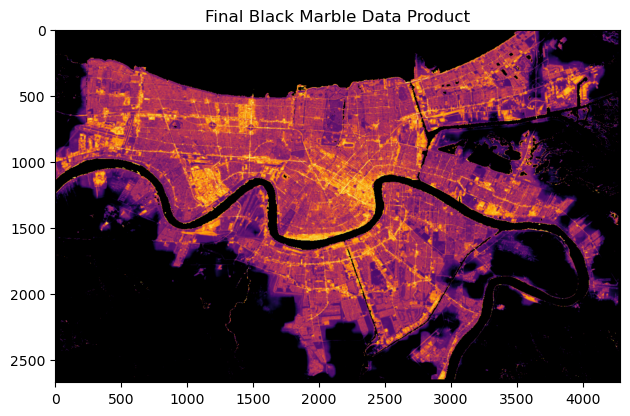

In [36]:
img = mpimg.imread('outputs/final/ndui-co.tif')
imgplot = plt.imshow(img)
plt.title("Final Black Marble Data Product")
plt.tight_layout()
plt.show()